## Simple qubit rotation with TFQ

In this jupyter file we define a variational quantum circuit $V(\theta)$ that rotates an initial state $|0000\rangle$ into a target state with equal superposition $\frac{1}{\sqrt{|\Sigma|}}\sum_{\sigma_i} | \sigma_i \rangle$. The aim is that  $\frac{1}{\sqrt{|\Sigma|}}\sum_{\sigma_i} \langle \sigma_i | V(\theta) | 0000\rangle = 1$.

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow.keras import Model

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Define the circuit with Cirq

To measure the overlap with the target state, we can simply measure the operator $M = 1/4*(X_1 + X_2 + X_3 + X_4)$
and minimize the loss $1-\langle M \rangle$.

We implement this mesurement operator as `op`

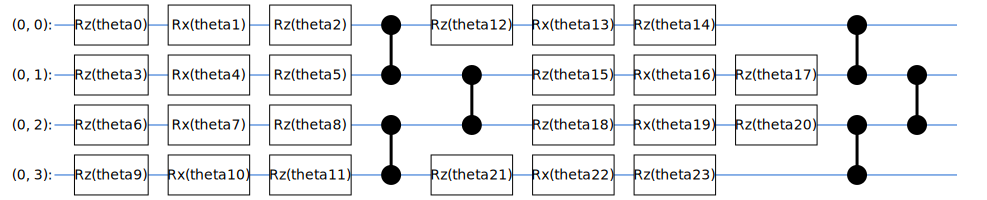

In [3]:
def generate_circuit(nr_of_qubits, layers):
    qubits = cirq.GridQubit.rect(1, nr_of_qubits) # Define qubit grid. In this case 
    nr_parameters = 3*nr_of_qubits*layers # 3 params for each qubit and layer

    symb = sympy.symbols('theta0:'+str(nr_parameters))
    symbols = np.array(symb)
    symbols = symbols.reshape(layers, nr_of_qubits, 3)
    circuit = cirq.Circuit()

    for l in range(layers):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            circuit += cirq.rz(symbols[l][i][0])(qubit)
            circuit += cirq.rx(symbols[l][i][1])(qubit)
            circuit += cirq.rz(symbols[l][i][2])(qubit)

        circuit += cirq.CZ(qubits[0], qubits[1])
        circuit += cirq.CZ(qubits[2], qubits[3])
        circuit += cirq.CZ(qubits[1], qubits[2])

    op = 1/4*(cirq.X(qubits[0]) + cirq.X(qubits[1]) + cirq.X(qubits[2]) + cirq.X(qubits[3]))         
    return circuit, op, list(symb)

nr_of_qubits = 4
layers = 2
tf_circuit, op, (symbols) = generate_circuit(nr_of_qubits, layers)
SVGCircuit(tf_circuit) 

## Method without keras

### Define a classical model that outputs the circuit parameters

These parameters will be trained. This is the basic structure this model needs to have. But we could `call()` any function or even whole nueral networks that return these parameters.

In [4]:
class circuit_params(Model):
    def __init__(self, W = np.random.normal(2)):
        super(circuit_params, self).__init__()

        self.W = tf.Variable(W)
    
    @tf.function
    def __call__(self):
        return self.W

model = circuit_params(W = np.random.rand(nr_of_qubits*layers*3))
model.trainable_variables

[<tf.Variable 'Variable:0' shape=(24,) dtype=float64, numpy=
 array([0.4139659 , 0.34282132, 0.87948004, 0.65461008, 0.32933811,
        0.80638918, 0.07704536, 0.03909048, 0.41425862, 0.14154555,
        0.72498658, 0.19544217, 0.87069088, 0.46945953, 0.05214077,
        0.87803274, 0.0761321 , 0.5159643 , 0.50242537, 0.1400908 ,
        0.05550696, 0.10629389, 0.16118076, 0.63178469])>]

### Make a test run to get the expectation

For a randomly initialized model we get the following expectation value

In [5]:
optimizer = tf.keras.optimizers.SGD(lr=0.5)

params = model()

out = tfq.layers.Expectation()(tf_circuit,
                         symbol_names=symbols,
                         symbol_values=[params],
                         operators=1-op)

out

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6974215]], dtype=float32)>

### Define training routine

For the training we call the model params and forward them to the TFQ layer for the expectation value. This calculations is intergrable with TFQ and we get the gradient and can update the parameters with the optimizer.

In [6]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        params = model()
        out = tfq.layers.Expectation()(tf_circuit,
                         symbol_names=symbols,
                         symbol_values=[params],
                         operators=1-op)
        
    gradients = tape.gradient(out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#### Run the training

In [9]:
for i in range(100):
    train_step()

#### Check training success

In [10]:
params = model()
out = tfq.layers.Expectation()(tf_circuit,
                 symbol_names=symbols,
                 symbol_values=[params],
                 operators=1-op)

out

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.2828579e-05]], dtype=float32)>

## Implement Keras method

This way is much shorter but it might give us less access to all the details of the circuit. And it is much slower than the other version.

### Transform circuit into TF layer

In [11]:
outputs = tfq.layers.PQC(tf_circuit,         # Circuit to be transformed into tf layer
                         1-op,               # Output of the layer
                         repetitions=1024,
                         differentiator=tfq.differentiators.ParameterShift())

### Define a model with a random input and the output of the quantum layer

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    outputs
])

In order to compile and fit the model, one needs to define a loss function (the quantity to optimize) and an optimizer. We want to optimize the expectation value of $M$, this is, the output of the model. Tensorflow needs this, however, as a function ``f(real_values,predictions)``

In [16]:
loss = lambda real, pred: pred    # Forget about any "real" values, just consider as loss the model's output

model.compile(loss=loss,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.4)) # Same optimizer as the Pennylane case

Finally, the ``fit`` function is designed for classification problems, and thus it needs of some inputs and corresponding "true" outputs. Our variational quantum circuit has none of these, so we just insert empty attributes: the input will be an empty quantum circuit, which corresponds to setting the initial state to $|0000\rangle$; the output will be an empty array (you can choose anything you want, since the loss function will discard whatever you set)

In [17]:
dummy_input  = tfq.convert_to_tensor([cirq.Circuit()])
dummy_output = np.array([[]])

In [ ]:
steps = 100
model.fit(dummy_input, dummy_output, epochs=steps)

Train on 1 samples
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 77)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 77)
1/1 [==============================] - 4s 4s/sample - loss: 1.0786
Epoch 2/100
1/1 [==============================] - 4s 4s/sample - loss: 0.9565
Epoch 3/100
1/1 [==============================] - 5s 5s/sample - loss: 0.8589
Epoch 4/100
1/1 [==============================] - 4s 4s/sample - loss: 0.7798
Epoch 5/100
1/1 [==============================] - 4s 4s/sample - loss: 0.7183
Epoch 6/100
